In [1]:
from random import *
import os
from tqdm import tqdm
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'
import PIL
import tensorflow as tf
import numpy as np
from keras import layers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.optimizers import SGD
from keras import Sequential
import warnings
import math
import sys
import gc

In [2]:
tf.random.set_seed(960312)
# pooling 5 status - 256 channels
def packet_drop(arr):
    index = randrange(256-8)
    arr[:,:,index:(index+8)] = 0
def error_injection(data):
    for img in tqdm(data):
        packet_drop(img)

In [3]:
path = "/media/2/Network/extracted_feature/whole_shuffle_to_19/with_error_whole/"

In [4]:
train_data = np.load(path+"whole_feature.npy",mmap_mode="r")
train_label = np.load(path+"whole_label.npy",mmap_mode="r")
train_data.shape, train_label.shape

((1279036, 7, 7, 512), (1279036, 1000))

In [5]:
test_data = np.load(path+"testing_features.npy",mmap_mode="r")
test_label = np.load(path+"testing_label.npy",mmap_mode="r")
test_data.shape, test_label.shape

((50000, 7, 7, 512), (50000, 1000))

In [6]:
"""
original_path = "/media/2/Network/extracted_feature/whole_shuffle_to_19/"
test_data_original = np.load(original_path+"testing_features.npy",mmap_mode="r")
test_label_original = np.load(original_path+"testing_label.npy",mmap_mode="r")
"""
#result = back_layer.evaluate(test_data_original,test_label_original)
 

'\noriginal_path = "/media/2/Network/extracted_feature/whole_shuffle_to_19/"\ntest_data_original = np.load(original_path+"testing_features.npy",mmap_mode="r")\ntest_label_original = np.load(original_path+"testing_label.npy",mmap_mode="r")\n'

In [ ]:

#SGD_optimizer = SGD(lr=1e-2, decay=5e-4, momentum=0.9, nesterov=False)
SGD_optimizer = tf.keras.optimizers.Adagrad(lr=0.01, decay=0)
multi_gpu= tf.distribute.MirroredStrategy()
with multi_gpu.scope():
    back_layer = load_model("/media/2/Network/pretrained_model/back_layers_19~.h5")
    back_layer.compile(optimizer=SGD_optimizer, loss='categorical_crossentropy',
                       metrics="acc")#[top_5])
back_layer.summary()
    # validation split이 0.2니까 training feature의 20%를 validation using
        
hist = back_layer.fit(train_data,train_label, epochs=1, verbose=1,
                             use_multiprocessing=True, validation_split=0.2,
                             batch_size=512,shuffle=True)
    ############ evaluate ####################


"""
        f = open("./result_tmp",mode="a")
        print("momentum :{} == {} th model Acc : {:.4}%, loss: {:.4}".format(momentum_var,i,result[1]*100,result[0]),file=f )
        print("momentum :{} == {} th model Acc : {:.4}%, loss: {:.4}".format(momentum_var,i,result[1]*100,result[0]) )
        f.close()
        if i !=0 and ( i%10==0 or i==9 ):
            back_layer.save("/media/3/Network/retrain_model_dir/pooling5/momentums/"+str(i)+"momentum_"+str(momentum_var)+"_back_layer_.h5")
        #del test_data, test_label
        gc.collect()
"""
gc.collect()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 1000)              4097000   
Total params: 123,642,856
Trainable params: 123,642,856
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/tas

In [8]:
result = back_layer.evaluate(test_data,test_label)

500/500 [==============================] - 12s 25ms/step - loss: 0.1845 - acc: 0.9687


In [10]:
i=0
print("{} th model Acc : {:.4}%, loss: {:.4}".format(i,result[1]*100,result[0]) )
    

0 th model Acc : 96.87%, loss: 0.1845


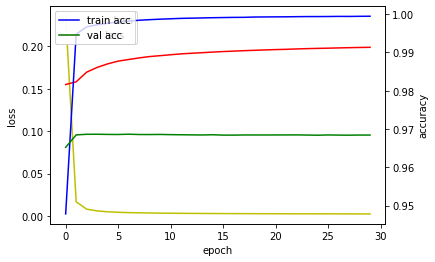

In [22]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [12]:
#momentums = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#momentums = [0.1,0.4,0.9]]
momentums = [0.1,0.4,0.9]
def top_5(y_true,y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true,y_pred,k=5)
warnings.simplefilter(action='ignore', category=FutureWarning)
for momentum_var in momentums :
    print(momentum_var,"starting")
    SGD_optimizer = SGD(lr=0.005, decay=1e-6, momentum=momentum_var, nesterov=True)
    back_layer = load_model("/media/2/Network/pretrained_model/back_layers_19~.h5")
    multi_gpu= tf.distribute.MirroredStrategy()
    with multi_gpu.scope():
        back_layer.compile(optimizer=SGD_optimizer, loss='categorical_crossentropy',
                       metrics="acc")#[top_5])
    back_layer.summary()
    # validation split이 0.2니까 training feature의 20%를 validation using
        
    hist = back_layer.fit(train_data,train_label, epochs=10, verbose=1,
                             use_multiprocessing=True, validation_split=0.2,
                             batch_size=256,shuffle=True)
    ############ evaluate ####################
    result = back_layer.evaluate(test_data,test_label)
    print("momentum :{} == {} th model Acc : {:.4}%, loss: {:.4}".format(momentum_var,i,result[1]*100,result[0]) )
    
    """
        f = open("./result_tmp",mode="a")
        print("momentum :{} == {} th model Acc : {:.4}%, loss: {:.4}".format(momentum_var,i,result[1]*100,result[0]),file=f )
        print("momentum :{} == {} th model Acc : {:.4}%, loss: {:.4}".format(momentum_var,i,result[1]*100,result[0]) )
        f.close()
        if i !=0 and ( i%10==0 or i==9 ):
            back_layer.save("/media/3/Network/retrain_model_dir/pooling5/momentums/"+str(i)+"momentum_"+str(momentum_var)+"_back_layer_.h5")
        #del test_data, test_label
        gc.collect()
    """
    gc.collect()
    

0.1 starting
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 1000)              4097000   
Total params: 123,642,856
Trainable params: 123,642,856
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
15988/15988 [==============================] - 244s 15ms/step - loss: 0.2189 - acc: 0.9507 - val_loss: 0.1521 - val_acc: 0.9653
Epoch 2/10
15988/15988 [==============================] - 247s 15ms/step - loss: 0.023

NameError: name 'i' is not defined